# Chapter 3 - Neural Computations


In [1]:
#Setup the environment
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.dists import Uniform
from nengo.processes import Piecewise

# 3.1 - Addition

In this model, you will see a transformation which is the basic property of single neurons (i.e., addition). Addition transforms two inputs into a single output which is their sum. You will construct a network that adds two inputs. The network utilizes two communication channels going into the same neural population. Addition is somewhat ‘free’, since the incoming currents from different synaptic connections interact linearly.

## Create the Model

This model has ensembles A and B which represent the two inputs to be added. The 'Sum' ensemble represents the added value. All the parameters used in the model are as described in the book, with the sum ensemble having a radius of 2 to account for the maximum range of summing the input values. 

While connecting the inputs to the ensembles A and B, the transform is set to 1 (which is the default value) since this should be a communication channel. However as described in the book, you can scale a represented variable by a constant value by changing the transform. Example: if you set the transform of ensemble B to 0 and ensemble A to 2 (i.e., nengo.Connection(input_A, A, transform=[2]) ), the sum will be twice of the input_A. You will also need to set an appropriate radius for the Sum ensemble to avoid saturation when you change the transform values.

In [2]:
#Create the network
model = nengo.Network(label='Scalar Addition')

with model:
    #Inputs to drive the activity in ensembles A and B 
    input_A = nengo.Node(Piecewise({0: -0.75, 1.25: 0.5, 2.5: 0.70, 3.75: 0}))
    input_B = nengo.Node(Piecewise({0: 0.25, 1.25: -0.5, 2.5: 0.85, 3.75: 0}))

    #Ensembles with 100 LIF neurons each
    A = nengo.Ensemble(100, dimensions=1, max_rates=Uniform(100, 200))             # Represents the first input
    B = nengo.Ensemble(100, dimensions=1, max_rates=Uniform(100, 200))             # Represents the second input
    Sum = nengo.Ensemble(100, dimensions=1, max_rates=Uniform(100, 200), radius=2) # Reprsents the sum of two inputs
        
    #Connecting the input nodes to ensembles
    nengo.Connection(input_A, A)
    nengo.Connection(input_B, B)
    
    #Connecting ensembles A and B to the Sum ensemble
    nengo.Connection(A, Sum)
    nengo.Connection(B, Sum)

## Add Probes to Collect Data

In [3]:
with model:
    input_A_probe = nengo.Probe(input_A)        # Input to ensemble A
    input_B_probe = nengo.Probe(input_B)        # Input to ensemble B
    A_probe = nengo.Probe(A, synapse=0.01)      # Decoded ouput of ensemble A
    B_probe = nengo.Probe(B, synapse=0.01)      # Decoded ouput of ensemble B
    Sum_probe = nengo.Probe(Sum, synapse=0.01)  # Decoded ouput of Sum ensemble

## Run the Model

Import the nengo_gui visualizer to run and visualize the model.

In [4]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "addition.py.cfg")

Press the play button in the visualizer to run the simulation. You should see the graphs as shown in the figure below.

The input_A and input_B graphs show the inputs to ensembles A and B respectively. The graphs A and B show the decoded value of the activity of ensembles A and B respectively. The sum graph shows that the decoded value of the activity in the Sum ensemble provides a good estimate of the sum of inputs A and B.

You can use the sliders to change the input values provided by the input_A and input_B nodes.

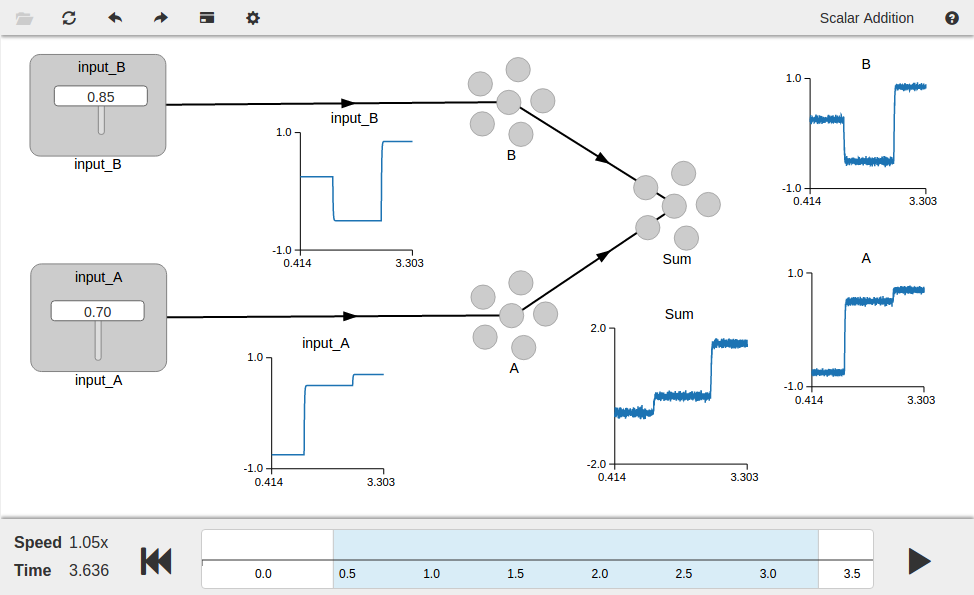

In [5]:
from IPython.display import Image
Image(filename='addition.png')

# 3.2 - Arbitrary Linear Transformation

This model shows that any linear transformation between ensembles can be easily computed by selecting an appropriate value for the "transform". It provides an example of computing linear transformations using vector representations.

Network diagram:

      [input - 2D] ---> (x - 2d) ---> (z - 3D)

A two-dimensional input signal is first fed into a two-dimensional neuronal ensemble `x` , which then projects it on to another three-dimensional ensemble `z`.

## Create the Model

This model contains the parameters as described in the book. Setting the transform equal to the 'weight_matrix' is analogous to entering the weights in the "2 to 3 Coupling Matrix" window in Nengo 1.4 GUI as described in the book. 

In [6]:
#Create a 'model' object to which we can add ensembles, connections, etc.  
model = nengo.Network(label="Arbitrary Linear Transformation")
with model:
    #Two-dimensional input signal with constant values of 0.5 and -0.5 in two dimensions
    input = nengo.Node(lambda t: [.5,-.5])
      
    #Ensembles with 200 LIF neurons having dimentions 2 and 3
    x = nengo.Ensemble(200, dimensions=2)
    z = nengo.Ensemble(200, dimensions=3)
       
    #Connect the input to ensemble x
    nengo.Connection(input, x)
    
    #Connect ensemble x to ensemble z using a weight matrix
    weight_matrix = [[0.0, 1.0], [1.0, 0.0], [0.5, 0.5]]   
    nengo.Connection(x, z, transform = weight_matrix)

## Run the Model

In [7]:
#Import the nengo_gui visualizer to run and visualize the model.
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "arbitrary_linear.py.cfg")

Press the play button in the visualizer to run the simulation. You should see the graphs as shown in the figure below.

The graphs show a two-dimesional input linearly projected on to a two-dimensional ensemble of neurons (`x`), which further linearly projects it on to a three-dimesional neuronal ensemble (`z`). You can use the sliders to change the input values provided by the input node.

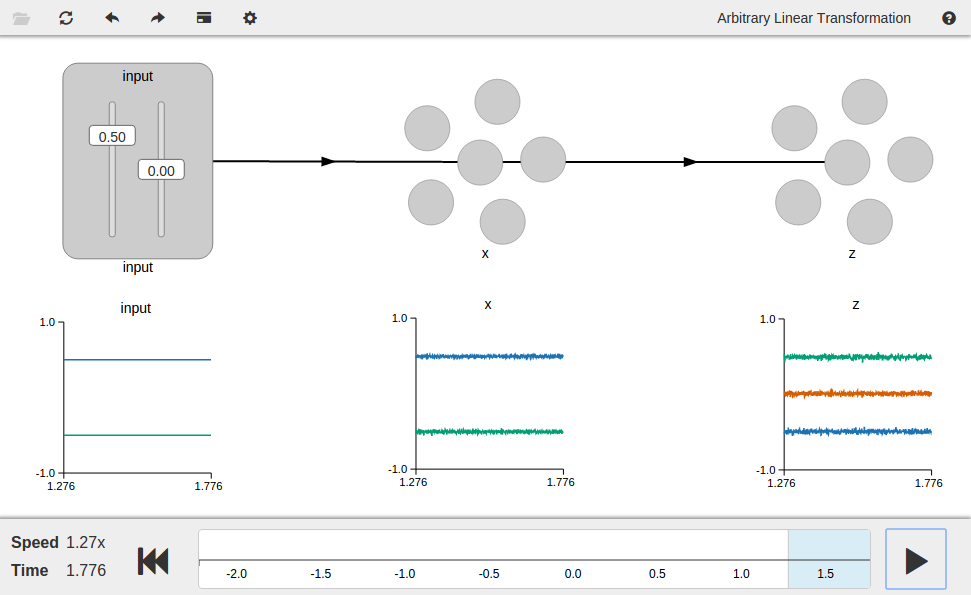

In [8]:
from IPython.display import Image
Image(filename='arbitrary_linear.png')

# 3.3 - Nonlinear Transformations

The real world is filled with non-linearities and so dealing with it often requires nonlinear computation. This model shows how to compute nonlinear functions using Nengo 3.0. The two nonlinear functions demonstrated in this model are 'multiplication' and 'squaring'.


## Create the Model

The parameters of the model are as described in the book. The model has five ensembles: two input ensembles (`X` and `Y`), a 2D combined ensemble (`vector2D`), and the output ensembles `result_square` and `result_product` which store the square and product of the inputs respectively. 

Two varying scalar values are used for the two input signals that drive activity in ensembles A and B. For multiplication, you will project both inputs independently into a 2D space, and then decode a nonlinear transformation of that space (i.e., the product) into an ensemble (`result_product`). The model also squares the value of the first input (`inputX`) encoded in an ensemble (X), in the output of another ensemble (`result_square`). 

The two functions `product(x)` and `square(x)` are defined to serve the same purpose as entering the expressions in the "Expression" field in the "User-defined Function" dialog box in Nengo 1.4 as described in the book.



In [9]:
model = nengo.Network(label='Nonlinear Function')
with model:
    #Input - Piecewise step functions
    inputX = nengo.Node(Piecewise({0: -0.75, 1.25: 0.5, 2.5: -0.75, 3.75: 0}))
    inputY= nengo.Node(Piecewise({0: 1, 1.25: 0.25, 2.5: -0.25, 3.75: 0.75}))
    
    #Five ensembles containing LIF neurons
    X = nengo.Ensemble(100, dimensions=1, radius=1)               # Represents inputX
    Y = nengo.Ensemble(100, dimensions=1, radius=1)               # Represents inputY
    vector2D = nengo.Ensemble(224, dimensions=2, radius=2)        # 2D combined ensemble
    result_square = nengo.Ensemble(100, dimensions=1, radius=1)   # Represents the square of X
    result_product = nengo.Ensemble(100, dimensions=1, radius=1)  # Represents the product of X and Y
    
    #Connecting the input nodes to the appropriate ensembles
    nengo.Connection(inputX, X)
    nengo.Connection(inputY, Y)
    
    #Connecting input ensembles A and B to the 2D combined ensemble
    nengo.Connection(X, vector2D[0])
    nengo.Connection(Y, vector2D[1])
    
    #Defining a function that computes the product of two inputs
    def product(x):
        return x[0] * x[1]
    
    #Defining the squaring function
    def square(x):
        return x[0] * x[0]
    
    #Connecting the 2D combined ensemble to the result ensemble 
    nengo.Connection(vector2D, result_product, function=product)
    
    #Connecting ensemble A to the result ensemble
    nengo.Connection(X, result_square, function=square)

## Run the Model

In [10]:
#Import the nengo_gui visualizer to run and visualize the model.
from nengo_gui.ipython import IPythonViz
IPythonViz(model, "non_linear.py.cfg")

Press the play button in the visualizer to run the simulation. You should see the graphs as shown in the figure below.

The input signals chosen clearly show that the model works well. The result_product graph shows the product of the `inputX` & `inputY`, and the `result_square` graph shows the squre of `inputX`. You can see in the graphs that when inputX is zero, both the product and the square are also zero. You can use the sliders to change the input values provided by the `inputX` and `inputY` nodes to test the model.

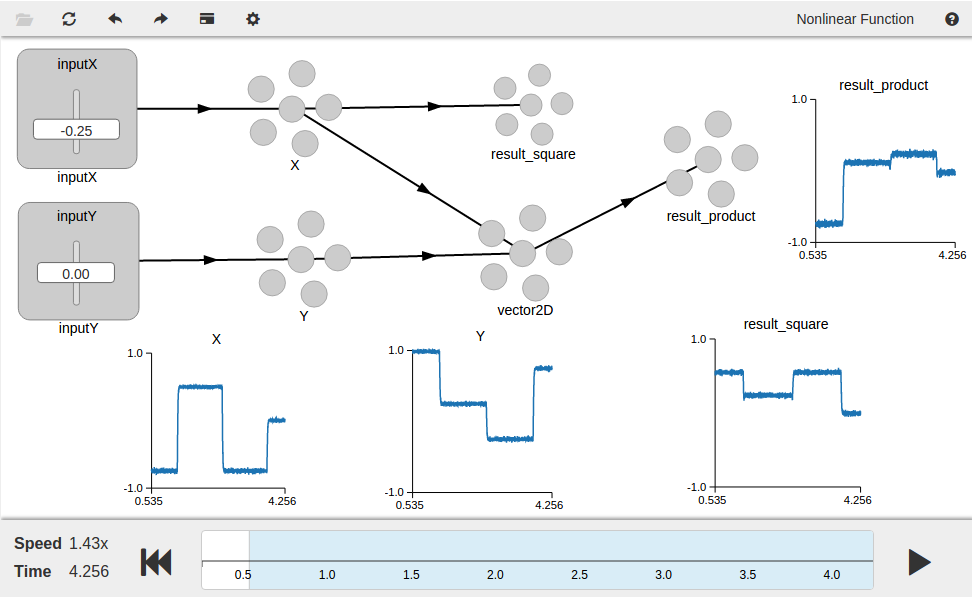

In [11]:
from IPython.display import Image
Image(filename='non_linear.png')